In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, adjusted_rand_score
import matplotlib.pyplot as plt
from pathlib import Path

# Set random seeds for reproducibility
RANDOM_SEED = 49
np.random.seed(RANDOM_SEED)

# Configuration flag: Set to True to balance classes (equal split)
BALANCE_CLASSES = True

# Define paths
project_root = Path().resolve().parent
data_file = project_root / "data" / "preprocessed" / "final_features_notebook.csv"

print("Loading data...")
# Load the data
df = pd.read_csv(data_file)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Separate features and target
target_col = 'team_a_won'
X = df.drop(columns=[target_col])
y = df[target_col]

print(f"\nFeatures: {X.shape[1]} columns")

# Verify streak features are included
streak_features = ['team_a_win_streak', 'team_a_loss_streak', 'team_b_win_streak', 'team_b_loss_streak']
streak_features_present = [f for f in streak_features if f in X.columns]
if len(streak_features_present) == len(streak_features):
    print(f"✅ Streak features included: {streak_features_present}")
else:
    print(f"⚠️  Some streak features missing. Found: {streak_features_present}")
    print(f"   Expected: {streak_features}")
print(f"Original target distribution:")
print(y.value_counts())
print(f"\nOriginal target percentage:")
print(y.value_counts(normalize=True) * 100)

# Balance classes if flag is set
if BALANCE_CLASSES:
    print(f"\n{'='*60}")
    print("BALANCING CLASSES (removing excess data from majority class)")
    print(f"{'='*60}")
    
    # Combine X and y for balancing
    df_combined = pd.concat([X, y], axis=1)
    
    # Get class counts
    class_counts = y.value_counts()
    minority_class = class_counts.idxmin()
    majority_class = class_counts.idxmax()
    minority_count = class_counts.min()
    
    print(f"Minority class ({minority_class}): {minority_count} samples")
    print(f"Majority class ({majority_class}): {class_counts.max()} samples")
    print(f"Will keep {minority_count} samples from each class")
    
    # Separate by class
    df_minority = df_combined[df_combined[target_col] == minority_class]
    df_majority = df_combined[df_combined[target_col] == majority_class]
    
    # Randomly sample from majority class to match minority class size
    df_majority_balanced = df_majority.sample(n=minority_count, random_state=RANDOM_SEED)
    
    # Combine balanced classes
    df_balanced = pd.concat([df_minority, df_majority_balanced], ignore_index=True)
    
    # Shuffle the balanced dataset
    df_balanced = df_balanced.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    
    # Separate back into X and y
    X = df_balanced.drop(columns=[target_col])
    y = df_balanced[target_col]
    
    print(f"\nAfter balancing:")
    print(f"  Total samples: {len(df_balanced)} (removed {len(df) - len(df_balanced)} samples)")
    print(f"  New target distribution:")
    print(y.value_counts())
    print(f"  New target percentage:")
    print(y.value_counts(normalize=True) * 100)
else:
    print(f"\nBALANCE_CLASSES is False - using original imbalanced dataset")

# Split into train and test sets (80/20) with stratification to maintain balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Train set class distribution:")
print(y_train.value_counts())
print(f"Train set class percentage:")
print(y_train.value_counts(normalize=True) * 100)

print(f"\nTest set: {X_test.shape[0]} samples")
print(f"Test set class distribution:")
print(y_test.value_counts())
print(f"Test set class percentage:")
print(y_test.value_counts(normalize=True) * 100)

print(f"\nInput feature size: {X_train.shape[1]}")


Loading data...
Dataset shape: (15744, 58)
Columns: ['map_id_31', 'map_id_32', 'map_id_33', 'map_id_34', 'map_id_35', 'map_id_40', 'map_id_46', 'map_id_47', 'map_id_48', 'team_a_wins_vs_b', 'team_a_losses_vs_b', 'team_a_total_vs_b', 'team_a_winrate_vs_b', 'team_a_map_wins', 'team_a_map_losses', 'team_a_map_total', 'team_a_map_winrate', 'team_b_map_wins', 'team_b_map_losses', 'team_b_map_total', 'team_b_map_winrate', 'team_a_win_streak', 'team_a_loss_streak', 'team_b_win_streak', 'team_b_loss_streak', 'team_a_player1_overall_rating', 'team_a_player1_utility_success', 'team_a_player1_opening_rating', 'team_a_player2_overall_rating', 'team_a_player2_utility_success', 'team_a_player2_opening_rating', 'team_a_player3_overall_rating', 'team_a_player3_utility_success', 'team_a_player3_opening_rating', 'team_a_player4_overall_rating', 'team_a_player4_utility_success', 'team_a_player4_opening_rating', 'team_a_player5_overall_rating', 'team_a_player5_utility_success', 'team_a_player5_opening_rat

In [217]:
# XGBoost Base Configuration
base_params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'logloss',  # Log loss for binary classification
    'random_state': RANDOM_SEED,
    'n_jobs': -1,  # Use all available cores
    'tree_method': 'hist'  # Histogram-based algorithm for faster training
}

print("XGBoost Base Parameters:")
print("=" * 60)
for key, value in base_params.items():
    print(f"  {key}: {value}")


XGBoost Base Parameters:
  objective: binary:logistic
  eval_metric: logloss
  random_state: 49
  n_jobs: -1
  tree_method: hist


In [218]:
# Hyperparameter Tuning using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time

print("=" * 60)
print("HYPERPARAMETER TUNING")
print("=" * 60)

# Define parameter grid for hyperparameter search
param_grid = {
    'max_depth': [4, 5, 6, 7, 8, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [100, 200, 300, 500],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.5, 1.0, 1.5, 2.0],
    'scale_pos_weight': [1]  # Keep balanced since we already balanced classes
}

# Create base model
base_model = xgb.XGBClassifier(**base_params)

# Use RandomizedSearchCV for faster search (tests random combinations)
# n_iter controls how many random combinations to try
print(f"\nSearching through hyperparameter space...")
print(f"Parameter combinations to try: {len(param_grid)} different parameters")
print(f"Using RandomizedSearchCV with 50 random combinations")

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings sampled
    scoring='f1',  # Use F1 score for evaluation
    n_jobs=-1,  # Use all available cores
    cv=3,  # 3-fold cross-validation
    verbose=2,  # Print progress
    random_state=RANDOM_SEED,
    return_train_score=True
)

# Perform hyperparameter search
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

print(f"\n✅ Hyperparameter search completed in {end_time - start_time:.2f} seconds")
print(f"\nBest parameters found:")
print("=" * 60)
best_params = random_search.best_params_
for key, value in sorted(best_params.items()):
    print(f"  {key}: {value}")

print(f"\nBest cross-validation F1 score: {random_search.best_score_:.4f}")
print(f"Best estimator: {random_search.best_estimator_}")

# Use the best model
model = random_search.best_estimator_


HYPERPARAMETER TUNING

Searching through hyperparameter space...
Parameter combinations to try: 10 different parameters
Using RandomizedSearchCV with 50 random combinations
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1.0, reg_lambda=1.0, scale_pos_weight=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1.0, reg_lambda=1.0, scale_pos_weight=1, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=300, reg_alpha=1.0, reg_lambda=1.0, scale_pos_weight=1, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=10, min_child_weight=5, n_estimators=300, reg_alpha=0.5, reg_lambda=1.5, scale_pos_weight=1, subsample

/Users/asad/Documents/repos/emils-demos/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=300, reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=20, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=1.0, scale_pos_weight=1, subsample=0.6; total time=   4.4s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1, subsample=0.8; total time=   1.2s
[CV] END colsample_

In [219]:
# Display hyperparameter search results
print("=" * 60)
print("HYPERPARAMETER SEARCH RESULTS SUMMARY")
print("=" * 60)

# Get results as DataFrame
results_df = pd.DataFrame(random_search.cv_results_)

# Sort by mean test score
results_df_sorted = results_df.sort_values('mean_test_score', ascending=False)

print(f"\nTop 5 hyperparameter combinations:")
print("=" * 60)
for idx, row in results_df_sorted.head(5).iterrows():
    print(f"\nRank {results_df_sorted.index.get_loc(idx) + 1}:")
    print(f"  Mean Test F1 Score: {row['mean_test_score']:.4f} (+/- {row['std_test_score']*2:.4f})")
    print(f"  Parameters:")
    for param in param_grid.keys():
        print(f"    {param}: {row[f'param_{param}']}")

print(f"\n{'='*60}")
print(f"Selected best model with F1 score: {random_search.best_score_:.4f}")
print(f"{'='*60}")


HYPERPARAMETER SEARCH RESULTS SUMMARY

Top 5 hyperparameter combinations:

Rank 1:
  Mean Test F1 Score: 0.6616 (+/- 0.0059)
  Parameters:
    max_depth: 5
    learning_rate: 0.01
    n_estimators: 300
    subsample: 0.7
    colsample_bytree: 0.7
    min_child_weight: 3
    gamma: 0.1
    reg_alpha: 0.0
    reg_lambda: 1.5
    scale_pos_weight: 1

Rank 2:
  Mean Test F1 Score: 0.6612 (+/- 0.0072)
  Parameters:
    max_depth: 4
    learning_rate: 0.05
    n_estimators: 100
    subsample: 0.8
    colsample_bytree: 0.9
    min_child_weight: 1
    gamma: 0.2
    reg_alpha: 1.0
    reg_lambda: 1.5
    scale_pos_weight: 1

Rank 3:
  Mean Test F1 Score: 0.6600 (+/- 0.0076)
  Parameters:
    max_depth: 4
    learning_rate: 0.01
    n_estimators: 300
    subsample: 0.6
    colsample_bytree: 0.8
    min_child_weight: 5
    gamma: 0.1
    reg_alpha: 0.0
    reg_lambda: 2.0
    scale_pos_weight: 1

Rank 4:
  Mean Test F1 Score: 0.6563 (+/- 0.0118)
  Parameters:
    max_depth: 5
    learning_rate: 

In [220]:
# Final Training with Best Parameters
print("=" * 60)
print("FINAL TRAINING WITH BEST PARAMETERS")
print("=" * 60)

# Set random seed
np.random.seed(RANDOM_SEED)

# Get best hyperparameters from RandomizedSearchCV
best_params = random_search.best_params_.copy()
best_params['random_state'] = RANDOM_SEED  # Use random seed 49

print(f"\nBest hyperparameters:")
for key, value in sorted(best_params.items()):
    print(f"  {key}: {value}")

# Create new model with best parameters
model = xgb.XGBClassifier(**best_params)

# Set early stopping for final training
early_stopping_rounds = 50
eval_set = [(X_train, y_train), (X_test, y_test)]

model.set_params(early_stopping_rounds=early_stopping_rounds)

print(f"\nTraining with best parameters and random seed {RANDOM_SEED}")
print(f"Early stopping patience: {early_stopping_rounds} rounds")
print(f"Monitoring: train and test sets")

# Train with evaluation set for monitoring
model.fit(
    X_train, 
    y_train,
    eval_set=eval_set,
    verbose=50  # Print every 50 rounds
)

print(f"\n✅ Final training completed!")
try:
    if hasattr(model, 'best_iteration') and model.best_iteration is not None:
        print(f"Best iteration: {model.best_iteration}")
        if hasattr(model, 'best_score'):
            print(f"Best score: {model.best_score:.4f}")
except AttributeError:
    print("Early stopping information not available")


FINAL TRAINING WITH BEST PARAMETERS

Best hyperparameters:
  colsample_bytree: 0.7
  gamma: 0.1
  learning_rate: 0.01
  max_depth: 5
  min_child_weight: 3
  n_estimators: 300
  random_state: 49
  reg_alpha: 0
  reg_lambda: 1.5
  scale_pos_weight: 1
  subsample: 0.7

Training with best parameters and random seed 49
Early stopping patience: 50 rounds
Monitoring: train and test sets
[0]	validation_0-logloss:0.69203	validation_1-logloss:0.69216
[50]	validation_0-logloss:0.65305	validation_1-logloss:0.66146
[100]	validation_0-logloss:0.63116	validation_1-logloss:0.64723
[150]	validation_0-logloss:0.61694	validation_1-logloss:0.64055
[200]	validation_0-logloss:0.60636	validation_1-logloss:0.63691
[250]	validation_0-logloss:0.59804	validation_1-logloss:0.63530
[299]	validation_0-logloss:0.59094	validation_1-logloss:0.63413

✅ Final training completed!
Best iteration: 299
Best score: 0.6341


In [221]:
# Get training history
results = model.evals_result()
train_logloss = results['validation_0']['logloss']
test_logloss = results['validation_1']['logloss']

print("Training History:")
print(f"  Final train logloss: {train_logloss[-1]:.4f}")
print(f"  Final test logloss: {test_logloss[-1]:.4f}")
print(f"  Best iteration: {model.best_iteration}")


Training History:
  Final train logloss: 0.5909
  Final test logloss: 0.6341
  Best iteration: 299


In [222]:
# Make predictions
print("=" * 60)
print("MAKING PREDICTIONS")
print("=" * 60)

# Get predictions and probabilities
train_predicted = model.predict(X_train)
train_probs = model.predict_proba(X_train)[:, 1]

test_predicted = model.predict(X_test)
test_probs = model.predict_proba(X_test)[:, 1]

print(f"Train predictions shape: {train_predicted.shape}")
print(f"Test predictions shape: {test_predicted.shape}")


MAKING PREDICTIONS
Train predictions shape: (11068,)
Test predictions shape: (2768,)


In [223]:
# Final evaluation
print("=" * 60)
print("FINAL MODEL EVALUATION")
print("=" * 60)

# Calculate metrics for training set
train_acc = accuracy_score(y_train, train_predicted)
train_prec = precision_score(y_train, train_predicted)
train_rec = recall_score(y_train, train_predicted)
train_f1 = f1_score(y_train, train_predicted)

print("\nTRAIN SET METRICS:")
print(f"Accuracy:  {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Precision: {train_prec:.4f}")
print(f"Recall:    {train_rec:.4f}")
print(f"F1-Score:  {train_f1:.4f}")

# Calculate metrics for test set
test_acc = accuracy_score(y_test, test_predicted)
test_prec = precision_score(y_test, test_predicted)
test_rec = recall_score(y_test, test_predicted)
test_f1 = f1_score(y_test, test_predicted)

print("\nTEST SET METRICS:")
print(f"Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Precision: {test_prec:.4f}")
print(f"Recall:    {test_rec:.4f}")
print(f"F1-Score:  {test_f1:.4f}")

# Confusion matrix
print("\nCONFUSION MATRIX (Test Set):")
cm = confusion_matrix(y_test, test_predicted)
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives:  {cm[1,1]}")

# Calculate ARI
ari = adjusted_rand_score(y_test.values.flatten(), test_predicted.flatten())
print(f"\nAdjusted Rand Index: {ari:.4f}")

# Classification report
print("\nCLASSIFICATION REPORT (Test Set):")
print(classification_report(y_test, test_predicted, target_names=['Team A Lost', 'Team A Won']))


FINAL MODEL EVALUATION

TRAIN SET METRICS:
Accuracy:  0.6930 (69.30%)
Precision: 0.6675
Recall:    0.7691
F1-Score:  0.7147

TEST SET METRICS:
Accuracy:  0.6337 (63.37%)
Precision: 0.6150
Recall:    0.7146
F1-Score:  0.6611

CONFUSION MATRIX (Test Set):
[[765 619]
 [395 989]]

True Negatives:  765
False Positives: 619
False Negatives: 395
True Positives:  989

Adjusted Rand Index: 0.0711

CLASSIFICATION REPORT (Test Set):
              precision    recall  f1-score   support

 Team A Lost       0.66      0.55      0.60      1384
  Team A Won       0.62      0.71      0.66      1384

    accuracy                           0.63      2768
   macro avg       0.64      0.63      0.63      2768
weighted avg       0.64      0.63      0.63      2768



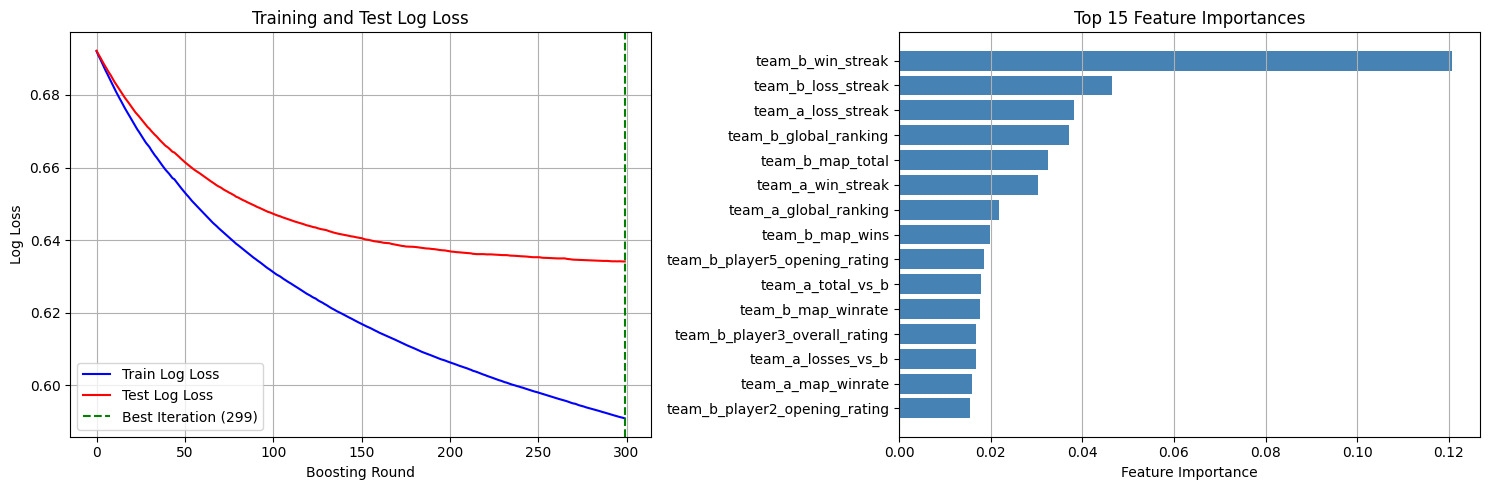


Best iteration: 299
Best test logloss: 0.6341
Final test logloss: 0.6341


In [224]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Log loss plot
axes[0].plot(train_logloss, label='Train Log Loss', color='blue')
axes[0].plot(test_logloss, label='Test Log Loss', color='red')
axes[0].axvline(x=model.best_iteration, color='green', linestyle='--', label=f'Best Iteration ({model.best_iteration})')
axes[0].set_xlabel('Boosting Round')
axes[0].set_ylabel('Log Loss')
axes[0].set_title('Training and Test Log Loss')
axes[0].legend()
axes[0].grid(True)

# Feature importance plot
feature_importance = model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(feature_importance)[::-1][:15]  # Top 15 features

axes[1].barh(range(len(indices)), feature_importance[indices], color='steelblue')
axes[1].set_yticks(range(len(indices)))
axes[1].set_yticklabels([feature_names[i] for i in indices])
axes[1].set_xlabel('Feature Importance')
axes[1].set_title('Top 15 Feature Importances')
axes[1].invert_yaxis()
axes[1].grid(True, axis='x')

plt.tight_layout()
plt.show()

print(f"\nBest iteration: {model.best_iteration}")
print(f"Best test logloss: {min(test_logloss):.4f}")
print(f"Final test logloss: {test_logloss[-1]:.4f}")


In [225]:
# Feature importance analysis
print("=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance_df.head(20).to_string(index=False))


FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features:
                      feature  importance
            team_b_win_streak    0.120727
           team_b_loss_streak    0.046562
           team_a_loss_streak    0.038149
        team_b_global_ranking    0.037011
             team_b_map_total    0.032594
            team_a_win_streak    0.030434
        team_a_global_ranking    0.021788
              team_b_map_wins    0.019774
team_b_player5_opening_rating    0.018539
            team_a_total_vs_b    0.017829
           team_b_map_winrate    0.017718
team_b_player3_overall_rating    0.016734
           team_a_losses_vs_b    0.016696
           team_a_map_winrate    0.015975
team_b_player2_opening_rating    0.015539
team_b_player4_opening_rating    0.015405
             team_a_wins_vs_b    0.015137
          team_a_winrate_vs_b    0.014716
team_b_player4_overall_rating    0.014504
                    map_id_40    0.014403


In [ ]:
# RECOMMENDATION 1: Filter matches with no history and retrain
print("=" * 60)
print("RECOMMENDATION 1: FILTERING MATCHES WITH NO HISTORY")
print("=" * 60)

# Reload original features
project_root = Path().resolve().parent
data_file = project_root / "data" / "preprocessed_data" / "final_features_notebook.csv"
df_filtered = pd.read_csv(data_file)
target_col = 'team_a_won'

# Filter out matches with no history
has_history = (
    (df_filtered['team_a_total_vs_b'] > 0) | 
    (df_filtered['team_a_map_total'] > 0) | 
    (df_filtered['team_b_map_total'] > 0)
)

df_with_history = df_filtered[has_history].copy()
print(f"\nOriginal matches: {len(df_filtered)}")
print(f"Matches with history: {len(df_with_history)} ({len(df_with_history)/len(df_filtered)*100:.1f}%)")
print(f"Removed: {len(df_filtered) - len(df_with_history)} matches ({100 - len(df_with_history)/len(df_filtered)*100:.1f}%)")

# Split filtered data
X_filtered = df_with_history.drop(columns=[target_col])
y_filtered = df_with_history[target_col]

X_train_filt, X_test_filt, y_train_filt, y_test_filt = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=RANDOM_SEED, stratify=y_filtered
)

print(f"\nFiltered train set: {len(X_train_filt)} samples")
print(f"Filtered test set: {len(X_test_filt)} samples")

# Train XGBoost on filtered data
print("\nTraining XGBoost on filtered data...")
model_filtered = xgb.XGBClassifier(**base_params)
model_filtered.set_params(early_stopping_rounds=50)

model_filtered.fit(
    X_train_filt,
    y_train_filt,
    eval_set=[(X_train_filt, y_train_filt), (X_test_filt, y_test_filt)],
    verbose=False
)

# Evaluate
train_pred_filt = model_filtered.predict(X_train_filt)
test_pred_filt = model_filtered.predict(X_test_filt)

train_acc_filt = accuracy_score(y_train_filt, train_pred_filt)
test_acc_filt = accuracy_score(y_test_filt, test_pred_filt)

print(f"\nFiltered Model Results:")
print(f"  Train Accuracy: {train_acc_filt:.4f} ({train_acc_filt*100:.2f}%)")
print(f"  Test Accuracy: {test_acc_filt:.4f} ({test_acc_filt*100:.2f}%)")
print(f"  Improvement: {test_acc_filt - test_acc:.4f} ({((test_acc_filt - test_acc)*100):.2f} percentage points)")


RECOMMENDATION 1: FILTERING MATCHES WITH NO HISTORY

Original matches: 15744
Matches with history: 15405 (97.8%)
Removed: 339 matches (2.2%)

Filtered train set: 12324 samples
Filtered test set: 3081 samples

Training XGBoost on filtered data...

Filtered Model Results:
  Train Accuracy: 0.7073 (70.73%)
  Test Accuracy: 0.6410 (64.10%)
  Improvement: 0.0074 (0.74 percentage points)
